In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('Official_final_dataset.csv')

In [2]:
# Use GroupShuffleSplit to stratify on the different municipalities

from sklearn.model_selection import StratifiedShuffleSplit, GroupShuffleSplit

group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for group_train_val_index, group_test_index in group_split.split(data, groups=data['Comune']):
    data_train_val = data.iloc[group_train_val_index]
    data_test = data.iloc[group_test_index]

group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for group_train_index, group_val_index in group_split.split(data_train_val, groups=data_train_val['Comune']):
    data_train = data_train_val.iloc[group_train_index]
    data_val = data_train_val.iloc[group_val_index]
    
print('Shape of the training set: ', data_train.shape)
print('Shape of the validation set: ', data_val.shape)
print('Shape of the test set: ', data_test.shape)

Shape of the training set:  (356, 55)
Shape of the validation set:  (92, 55)
Shape of the test set:  (112, 55)


In [3]:
# Data augmentation
augmentation_df = pd.DataFrame(columns=data_train.columns)
X = data_train.iloc[:,1:-1]
y = pd.concat([data_train.iloc[:,0], data_train.iloc[:,-1]], axis=1)

for row, factor in enumerate(X['Multiplicator']):
    for rep in range(round(factor)):
        dummy_X = pd.DataFrame(np.repeat(X[X.index == row].values, 1, axis=0), columns=X.columns)
        dummy_X = dummy_X.add(np.random.normal(0, abs(dummy_X.values)/10, dummy_X.shape))
        dummy_y = pd.DataFrame(np.repeat(y[y.index == row].values, 1, axis=0), columns=['Comune', 'Label'])
        dummy = pd.concat([dummy_y.iloc[:,0], dummy_X, dummy_y.iloc[:,-1]], axis=1)
        augmentation_df = pd.concat([augmentation_df, dummy])

augmentation_df = augmentation_df.reset_index(drop=True)
augmentation_df['frequency_NO2'] = (augmentation_df['frequency_NO2'].apply(lambda x: round(x))).astype('int64')
augmentation_df['frequency_CO'] = (augmentation_df['frequency_CO'].apply(lambda x: round(x))).astype('int64')
augmentation_df['frequency_O3'] = (augmentation_df['frequency_O3'].apply(lambda x: round(x))).astype('int64')
augmentation_df['frequency_PM10'] = (augmentation_df['frequency_PM10'].apply(lambda x: round(x))).astype('int64')

In [4]:
data_train = pd.concat([data_train, augmentation_df], ignore_index=True)
data_train = data_train.drop(['Multiplicator', 'Cardio_incidence', 'Year', 'Comune'], axis=1)

data_val = data_val.drop(['Multiplicator', 'Cardio_incidence', 'Year', 'Comune'], axis=1)
data_test = data_test.drop(['Multiplicator', 'Cardio_incidence', 'Year', 'Comune'], axis=1)

In [5]:
X_train = data_train.iloc[:,:-1]
X_val = data_val.iloc[:,:-1]
X_test = data_test.iloc[:,:-1]
y_train = data_train.iloc[:,-1].astype('int64')
y_val = data_val.iloc[:,-1].astype('int64')
y_test = data_test.iloc[:,-1].astype('int64')

print('Training set dimension: ' + str(X_train.shape))
print('Validation set dimension: ' + str(X_val.shape))
print('Test set dimension: ' + str(X_test.shape))

Training set dimension: (862, 50)
Validation set dimension: (92, 50)
Test set dimension: (112, 50)


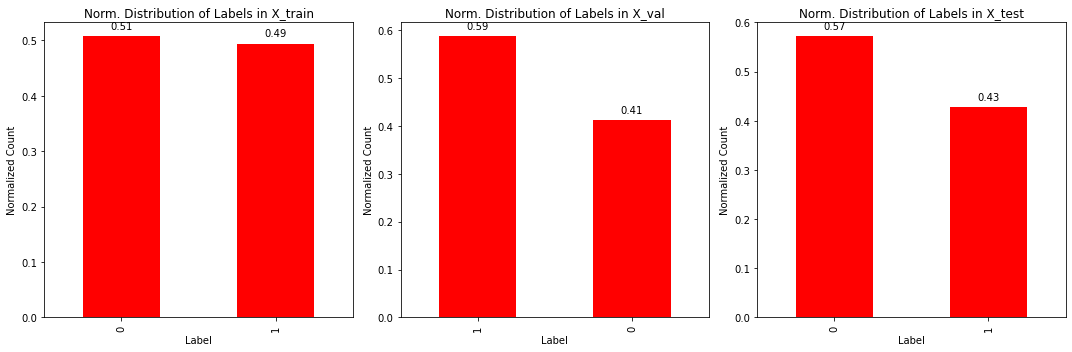

In [6]:
import matplotlib.pyplot as plt

## Plot distributions in each set
def plot_normalized_label_distribution(data, title, ax):
    temp_df = pd.DataFrame(data=data, columns=['Label'])
    label_counts = temp_df['Label'].value_counts(normalize=True)
    label_counts.plot(kind='bar', ax=ax, color='red')
    ax.set_title(f'Norm. Distribution of Labels in {title}')
    ax.set_xlabel('Label')
    ax.set_ylabel('Normalized Count')

    # Add text annotations above each bar
    for i, count in enumerate(label_counts):
        ax.text(i, count + 0.01, f'{count:.2f}', ha='center', va='bottom')

# Create subplots with one row and three columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the normalized distribution in the final training set
plot_normalized_label_distribution(y_train, 'X_train', axs[0])

# Plot the normalized distribution in the validation set
plot_normalized_label_distribution(y_val, 'X_val', axs[1])

# Plot the normalized distribution in the test set
plot_normalized_label_distribution(y_test, 'X_test', axs[2])

plt.tight_layout()
plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)

X_val_scaled = scaler.transform(X_val)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

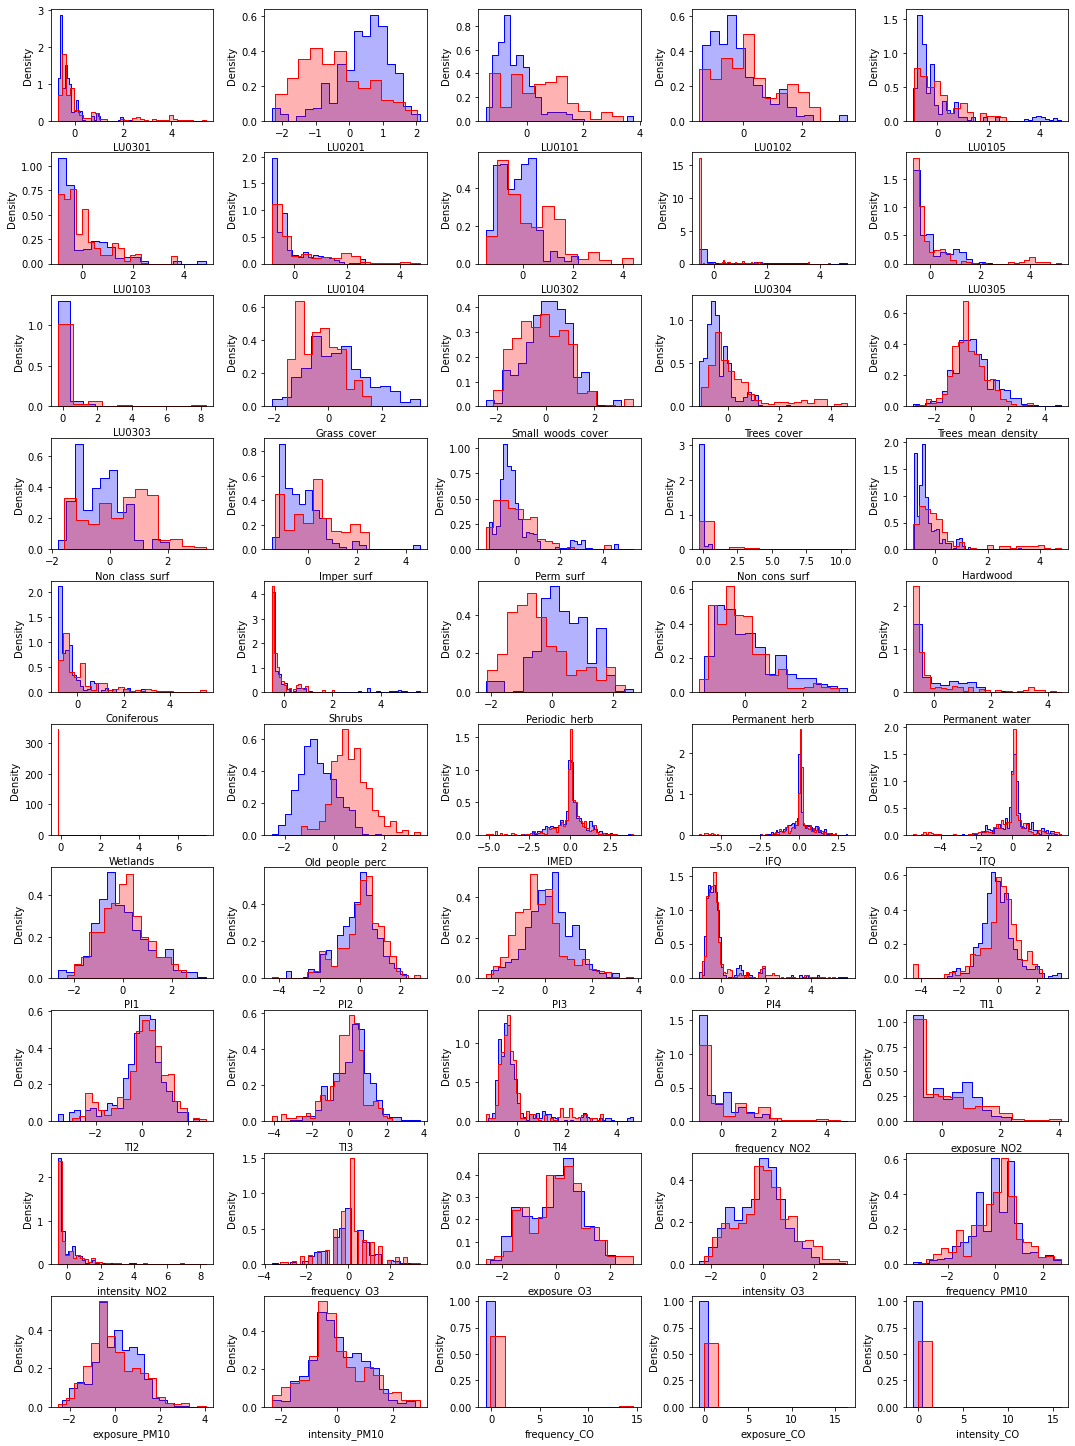

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
## Look at the distributions, from this picture we can see which features are more important to discriminate between classes and
## which ones are not.
y_train_arr = np.array(y_train)
X0 = X_train[y_train_arr == 0]
X1 = X_train[y_train_arr == 1]
fig, axes = plt.subplots(ncols=5, nrows=10, figsize=(15,20))
fig.tight_layout()
for i, ax in zip(range(X_train.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step", alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step", alpha=0.3)
plt.show()

### Feature selection

In [9]:
from sklearn.feature_selection import VarianceThreshold

var_thr = VarianceThreshold(threshold = 0.01) #Removing both constant and quasi-constant
var_thr.fit(X_train)

var_thr.get_support()

concol = [column for column in X_train.columns
          if column not in X_train.columns[var_thr.get_support()]]

if len(concol) == 0:
    print('No features to drop!')
else:
    for features in concol:
        print(features)

No features to drop!


In [10]:
## Function to plot correlation matrix
def plot_correlationMatrix(correlation_matrix, features):
    f = plt.figure(figsize=(12, 10))
    plt.matshow(correlation_matrix, fignum=f.number)
    plt.xticks(range(len(features)), features, fontsize=12, rotation=90)
    plt.yticks(range(len(features)), features, fontsize=12)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #plt.title('Correlation Matrix', fontsize=16)
    # plt.tight_layout()
    return

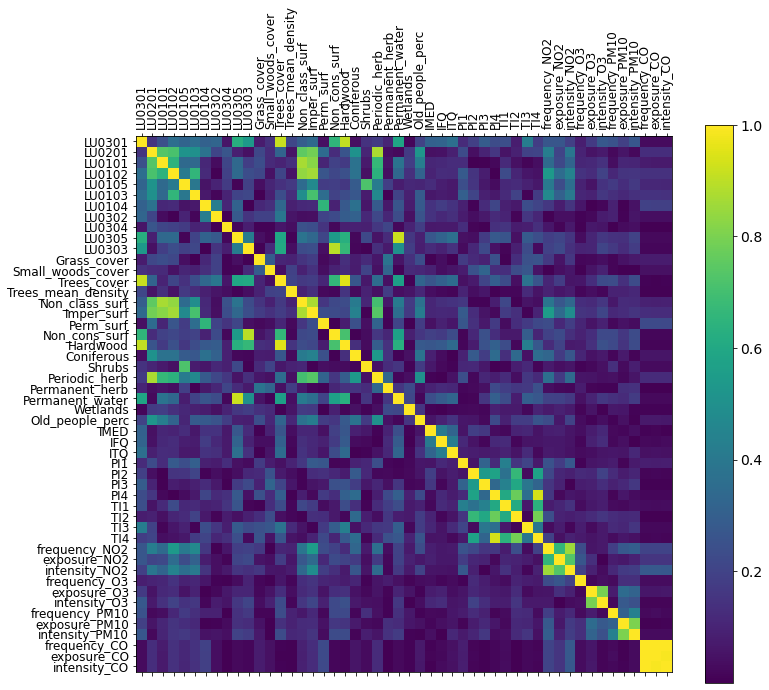

In [11]:
## Eliminate correlated features
cor_matrix = X_train.corr().abs()
plot_correlationMatrix(cor_matrix, X_train.columns)

Deleted features: {'TI4', 'Imper_surf', 'LU0303', 'Permanent_water', 'frequency_CO', 'Periodic_herb', 'LU0101', 'intensity_NO2', 'exposure_CO', 'Non_class_surf', 'Hardwood', 'Trees_cover'}

 (862, 38) (112, 38)


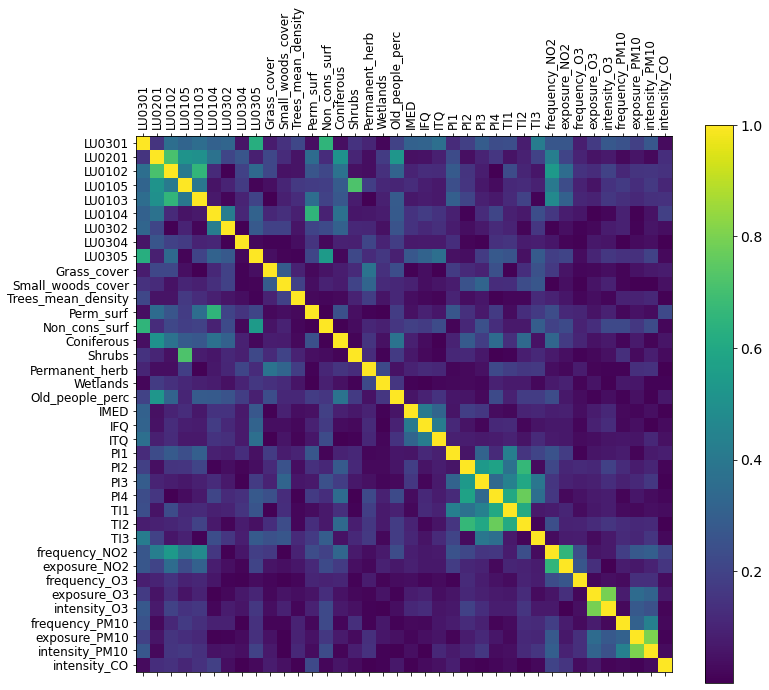

In [12]:
correlated_features = set()
correlation_matrix = X_train.corr()
median_corr = (correlation_matrix.abs()).median(axis=0)

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85:
            if median_corr[i] < median_corr[j]:
                colname = correlation_matrix.columns[i]
            else:
                colname = correlation_matrix.columns[j]
            correlated_features.add(colname)
X_train.drop(labels=correlated_features, axis=1, inplace=True)
## See how it drops correlated / drop the one that had a lower correlation w.r to the other feat
print('Deleted features: ' + str(correlated_features))

## Plot correlation matrix with remaining features
cor_matrix = X_train.corr().abs()
feature_list = list(X_train.columns)
f2 = plot_correlationMatrix(cor_matrix, feature_list)

## Adapt test set: pick only selected features
# X_val = X_val[feature_list]
X_test = X_test[feature_list]

## Check shape of the datasets
print('\n', X_train.shape, X_test.shape)

Optimal number of features : 36


,ranking,selected
LU0301,1,True
LU0201,1,True
LU0102,1,True
LU0105,1,True
LU0103,1,True
LU0104,1,True
LU0302,1,True
LU0304,1,True
LU0305,1,True
Grass_cover,1,True


,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.882881,0.043293,0.907514,0.815029,0.848837,0.918605,0.924419
1,0.885193,0.044277,0.907514,0.826590,0.837209,0.924419,0.930233
2,0.886349,0.046148,0.901734,0.838150,0.825581,0.936047,0.930233
3,0.885200,0.043205,0.895954,0.832370,0.837209,0.936047,0.924419
4,0.888675,0.040814,0.901734,0.838150,0.843023,0.924419,0.936047
5,0.881698,0.044366,0.907514,0.832370,0.825581,0.906977,0.936047
6,0.886362,0.050538,0.907514,0.820809,0.831395,0.930233,0.941860
7,0.881731,0.044124,0.884393,0.826590,0.837209,0.930233,0.930233
8,0.891034,0.052761,0.901734,0.809249,0.854651,0.941860,0.947674
9,0.880548,0.036510,0.890173,0.838150,0.837209,0.918605,0.918605


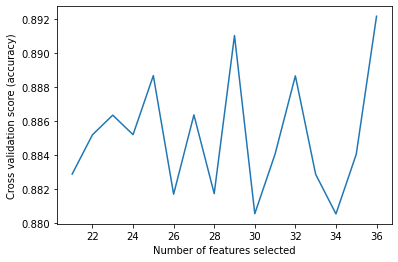

In [20]:
## Recurrent feature elimination
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

clf = RandomForestClassifier(random_state=42)
min_features_to_select = 21

rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5), scoring='accuracy',
              min_features_to_select=min_features_to_select, n_jobs=-1)

rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

fs_results_2 = pd.DataFrame({'ranking': rfecv.ranking_, 'selected': rfecv.support_},
                              index = [rfecv.feature_names_in_])

display(fs_results_2)

fs_results_1 = pd.DataFrame(rfecv.cv_results_)
display(fs_results_1)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
n_features = len(rfecv.cv_results_['mean_test_score'])
plt.plot(range(min_features_to_select, min_features_to_select + n_features), rfecv.cv_results_['mean_test_score'])
plt.show()

In [14]:
## Adapt train & validation set
X_train = X_train.iloc[:, rfecv.support_]
X_val = X_val[X_train.columns]
X_test = X_test[X_train.columns]
print(X_train.shape, X_val.shape, X_test.shape)

(862, 36) (92, 36) (112, 36)


### Models training

##### Random forest

In [16]:
# Grid search CV with scoring f1

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def hyperp_search(classifier, parameters, X_train, y_train):
    gs = GridSearchCV(classifier, parameters, cv = 5, scoring = 'accuracy', verbose = 0, n_jobs= -1, refit=True)
    gs = gs.fit(X_train, y_train)
    print("Accuracy_train: %f using %s" % (gs.best_score_, gs.best_params_))
    best_model = gs.best_estimator_
    y_pred_proba = best_model.predict_proba(X_val)
    y_pred = best_model.predict(X_val)
    y_pred_train = best_model.predict(X_train)
    print("ACCURACY train %.3f val %.3f" % (accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred))) 
    print("PRECISION train %.3f val %.3f" % (precision_score(y_train, y_pred_train), precision_score(y_val, y_pred))) 
    print("RECALL train %.3f val %.3f" % (recall_score(y_train, y_pred_train), recall_score(y_val, y_pred)))
    print("F1 train %.3f val %.3f" % (f1_score(y_train, y_pred_train), f1_score(y_val, y_pred)))
    print("")
    ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
    return np.asarray(y_pred_proba)


------------ RESULTS RANDOM FOREST  ------------
Accuracy_train: 0.871266 using {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 25, 'n_estimators': 100}
ACCURACY train 0.928 val 0.848
PRECISION train 0.921 val 0.845
RECALL train 0.934 val 0.907
F1 train 0.928 val 0.875



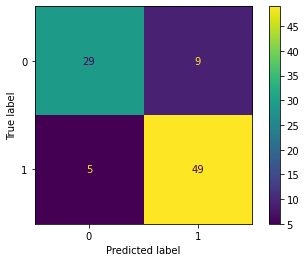

In [19]:
from sklearn.ensemble import RandomForestClassifier

classifier= RandomForestClassifier()
parameters = {'n_estimators' : [100, 125, 150], 'criterion' : ['entropy', 'gini'], 'max_depth' : [5,6,7], 
 'min_samples_split' : [25,30,35],
 'min_samples_leaf' : [20,25,30]
 }

print("\n------------ RESULTS RANDOM FOREST  ------------")
Predictions_RF = hyperp_search(classifier, parameters, X_train, y_train)

Random Forest: ROC AUC = 0.921


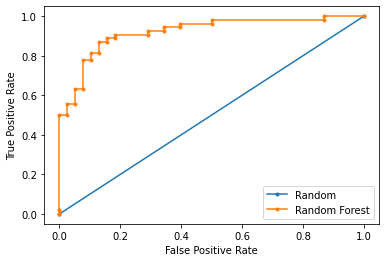

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Display the ROC curve and the AUC
## Calculate scores
RF_auc = roc_auc_score(y_val, Predictions_RF[:,1])
print('Random Forest: ROC AUC = %.3f' % (RF_auc))

## Calculate roc curves
RF_fpr, RF_tpr, _ = roc_curve(y_val, Predictions_RF[:,1])

## Plot the roc curve for the model
plt.plot([0, 1], [0, 1], marker='.', label='Random')
plt.plot(RF_fpr, RF_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

##### Logistic regression


------------ RESULTS LOGISTIC REGRESSION ------------
Accuracy_train: 0.836443 using {'C': 0.1, 'max_iter': 100}
ACCURACY train 0.881 val 0.804
PRECISION train 0.885 val 0.781
RECALL train 0.871 val 0.926
F1 train 0.878 val 0.847



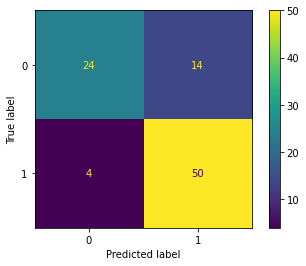

In [39]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
parameters = {"C":[1e-4,1e-3,1e-2,1e-1,1,10], "max_iter":[100, 250, 500, 1000]}

print("\n------------ RESULTS LOGISTIC REGRESSION ------------")
Predictions_lr = hyperp_search(classifier,parameters, X_train, y_train)

Logistic regression: ROC AUC = 0.827


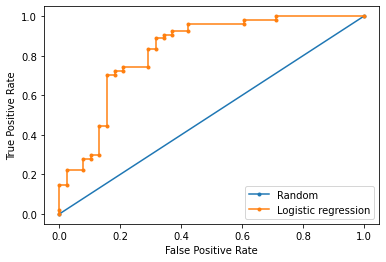

In [22]:
## Display the ROC curve and the AUC
## Calculate scores
lr_auc = roc_auc_score(y_val, Predictions_lr[:,1])
print('Logistic regression: ROC AUC = %.3f' % (lr_auc))

## Calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_val, Predictions_lr[:,1])

## Plot the roc curve for the model
plt.plot([0, 1], [0, 1], marker='.', label='Random')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

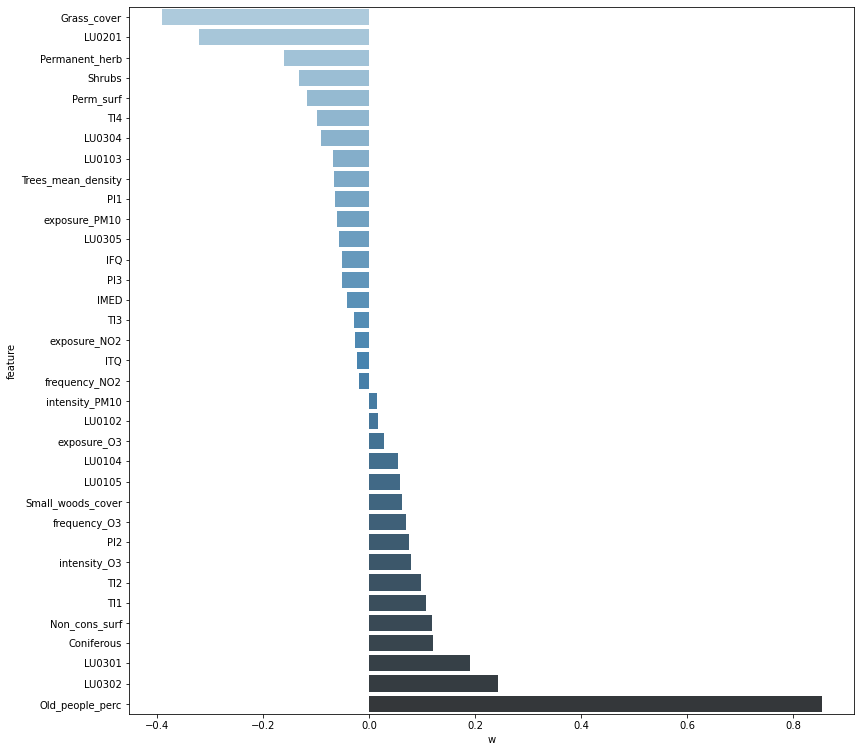

In [23]:
import seaborn as sns
model_lr = LogisticRegression(C=0.01, max_iter=100)
model_lr.fit(X_train, y_train)
coeff=pd.DataFrame()
coeff["feature"]=X_train.columns
coeff["w"]= model_lr.coef_[0]
coeff.sort_values(by=['w'], inplace=True)

fig, ax = plt.subplots(figsize=(13, 13))
sns.barplot(data=coeff, y="feature", x="w", palette="Blues_d", orient="h")
plt.show()

##### Neural networks


------------ RESULTS NN ------------
Accuracy_train: 0.856143 using {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (7, 3), 'learning_rate': 'adaptive', 'max_iter': 2000}
ACCURACY train 0.998 val 0.793
PRECISION train 1.000 val 0.797
RECALL train 0.995 val 0.870
F1 train 0.998 val 0.832



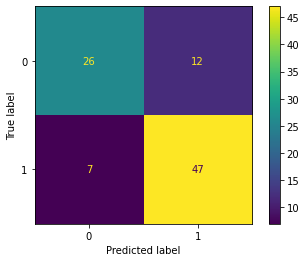

In [24]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(7,3), (7,5), (5,5)], "activation":["relu"], "max_iter":[2000], "learning_rate":["adaptive"], "alpha": [0.001,0.01]}

print("\n------------ RESULTS NN ------------")
Predictions_NN = hyperp_search(classifier,parameters, X_train, y_train)

Neural Network: ROC AUC = 0.820


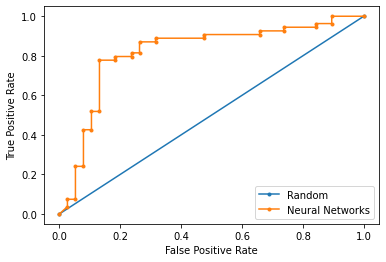

In [25]:
## Display the ROC curve and the AUC
## Calculate scores
nn_auc = roc_auc_score(y_val, Predictions_NN[:,1])
print('Neural Network: ROC AUC = %.3f' % (nn_auc))

## Calculate roc curves
nn_fpr, nn_tpr, _ = roc_curve(y_val, Predictions_NN[:,1])

## Plot the roc curve for the model
plt.plot([0, 1], [0, 1], marker='.', label='Random')
plt.plot(nn_fpr, nn_tpr, marker='.', label='Neural Networks')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

##### KNN


------------ RESULTS KNN ------------
Accuracy_train: 0.797090 using {'n_neighbors': 23}
ACCURACY train 0.899 val 0.804
PRECISION train 0.867 val 0.781
RECALL train 0.939 val 0.926
F1 train 0.902 val 0.847



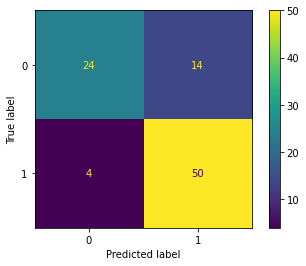

In [34]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(21,51,2)}

print("\n------------ RESULTS KNN ------------")
Predictions_KNN = hyperp_search(classifier,parameters, X_train, y_train)

KNN: ROC AUC = 0.792


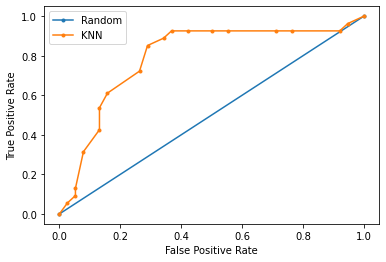

In [35]:
## Display the ROC curve and the AUC
## Calculate scores
KNN_auc = roc_auc_score(y_val, Predictions_KNN[:,1])
print('KNN: ROC AUC = %.3f' % (KNN_auc))

## Calculate roc curves
KNN_fpr, KNN_tpr, _ = roc_curve(y_val, Predictions_KNN[:,1])

## Plot the roc curve for the model
plt.plot([0, 1], [0, 1], marker='.', label='Random')
plt.plot(KNN_fpr, KNN_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

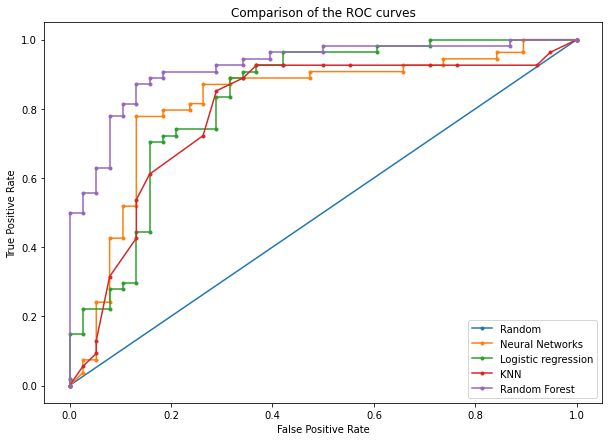

In [36]:
## Compare the results of the different ensemble models

fig = plt.subplots(figsize=(10, 7))
plt.plot([0, 1], [0, 1], marker='.', label='Random')
plt.plot(nn_fpr, nn_tpr, marker='.', label='Neural Networks')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic regression')
plt.plot(KNN_fpr, KNN_tpr, marker='.', label='KNN')
plt.plot(RF_fpr, RF_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of the ROC curves')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Comparison of accuracy'}>

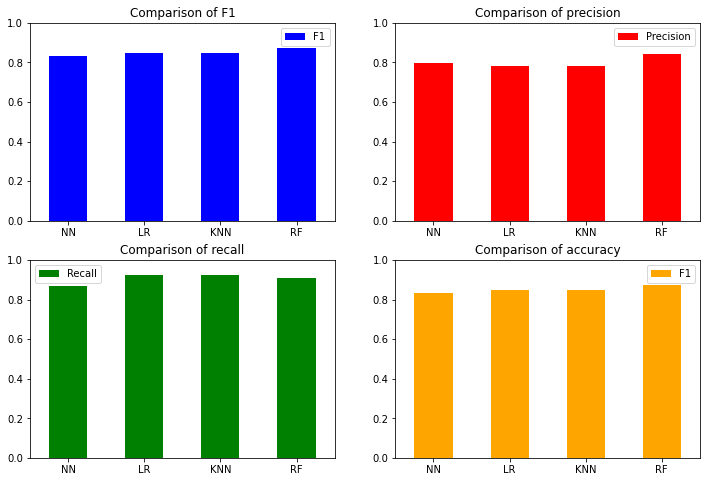

In [37]:
## Compare results

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.ylim([0,1])
index = ['NN', 'LR', 'KNN', 'RF']

values = pd.DataFrame(data = [accuracy_score(y_val, Predictions_NN.argmax(axis=1)), 
             accuracy_score(y_val, Predictions_lr.argmax(axis=1)), accuracy_score(y_val, Predictions_KNN.argmax(axis=1)), 
             accuracy_score(y_val, Predictions_RF.argmax(axis=1))], columns=['Accuracy'], index=index)

values = pd.DataFrame(data = [precision_score(y_val, Predictions_NN.argmax(axis=1)), 
             precision_score(y_val, Predictions_lr.argmax(axis=1)), precision_score(y_val, Predictions_KNN.argmax(axis=1)), 
             precision_score(y_val, Predictions_RF.argmax(axis=1))], columns=['Precision'], index=index)
values.plot(kind='bar', ax = axs[0,1], color='red', ylim=(0,1), title='Comparison of precision', rot=0)

values = pd.DataFrame(data = [recall_score(y_val, Predictions_NN.argmax(axis=1)), 
             recall_score(y_val, Predictions_lr.argmax(axis=1)), recall_score(y_val, Predictions_KNN.argmax(axis=1)), 
             recall_score(y_val, Predictions_RF.argmax(axis=1))], columns=['Recall'], index=index)
values.plot(kind='bar', ax = axs[1,0], color='green', ylim=(0,1), title='Comparison of recall', rot=0)

values = pd.DataFrame(data = [f1_score(y_val, Predictions_NN.argmax(axis=1)), 
             f1_score(y_val, Predictions_lr.argmax(axis=1)), f1_score(y_val, Predictions_KNN.argmax(axis=1)), 
             f1_score(y_val, Predictions_RF.argmax(axis=1))], columns=['F1'], index=index)
values.plot(kind='bar', ax = axs[0,0], color='blue', ylim=(0,1), title='Comparison of F1', rot=0)

values.plot(kind='bar', ax = axs[1,1], color='orange', ylim=(0,1), title='Comparison of accuracy', rot=0)

### Final model assessment

In [40]:
X = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val])

print(X.shape, y.shape)

(954, 35) (954,)


ACCURACY score 0.741
PRECISION score 0.686
RECALL score 0.729
F1 score 0.707



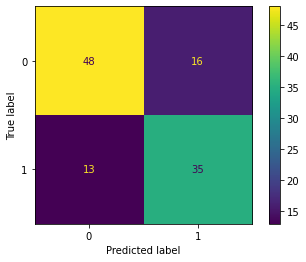

In [52]:
best_model = RandomForestClassifier(criterion = 'entropy', max_depth = 6, min_samples_leaf = 20,
                                    min_samples_split = 25, n_estimators = 100, random_state=42)
# best_model = LogisticRegression(C=0.01, max_iter=100)
best_model = best_model.fit(X,y)
y_pred_proba = best_model.predict_proba(X_test)

print("ACCURACY score %.3f" % (accuracy_score(y_test, y_pred_proba.argmax(axis=1)))) 
print("PRECISION score %.3f" % (precision_score(y_test, y_pred_proba.argmax(axis=1)))) 
print("RECALL score %.3f" % (recall_score(y_test, y_pred_proba.argmax(axis=1))))
print("F1 score %.3f" % (f1_score(y_test, y_pred_proba.argmax(axis=1))))
print("")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_proba.argmax(axis=1))

Feature: LU0301 Score: 0.34912729414836896
Feature: Coniferous Score: 0.3385464321066287
Feature: LU0201 Score: 0.33098249216930054
Feature: Shrubs Score: 0.32031785721420825
Feature: Grass_cover Score: 0.30323155489399234
Feature: Old_people_perc Score: 0.3009472784576177
Feature: LU0104 Score: 0.29920337505705596
Feature: LU0103 Score: 0.2984669542649625
Feature: LU0105 Score: 0.2978884849172596
Feature: Perm_surf Score: 0.28681245041393755
Feature: LU0305 Score: 0.28663074120981946
Feature: LU0302 Score: 0.2852579470359933
Feature: LU0102 Score: 0.2744788115045971
Feature: Small_woods_cover Score: 0.24608590694298993
Feature: Permanent_herb Score: 0.233496987266399
Feature: Trees_mean_density Score: 0.21584632776205837
Feature: LU0304 Score: 0.1165635877376543
Feature: Non_cons_surf Score: 0.07016415372131313
Feature: TI4 Score: 0.04581780043940942
Feature: TI1 Score: 0.04535707673980838
Feature: IMED Score: 0.03894620731854026
Feature: frequency_O3 Score: 0.035343050206475546
Featu

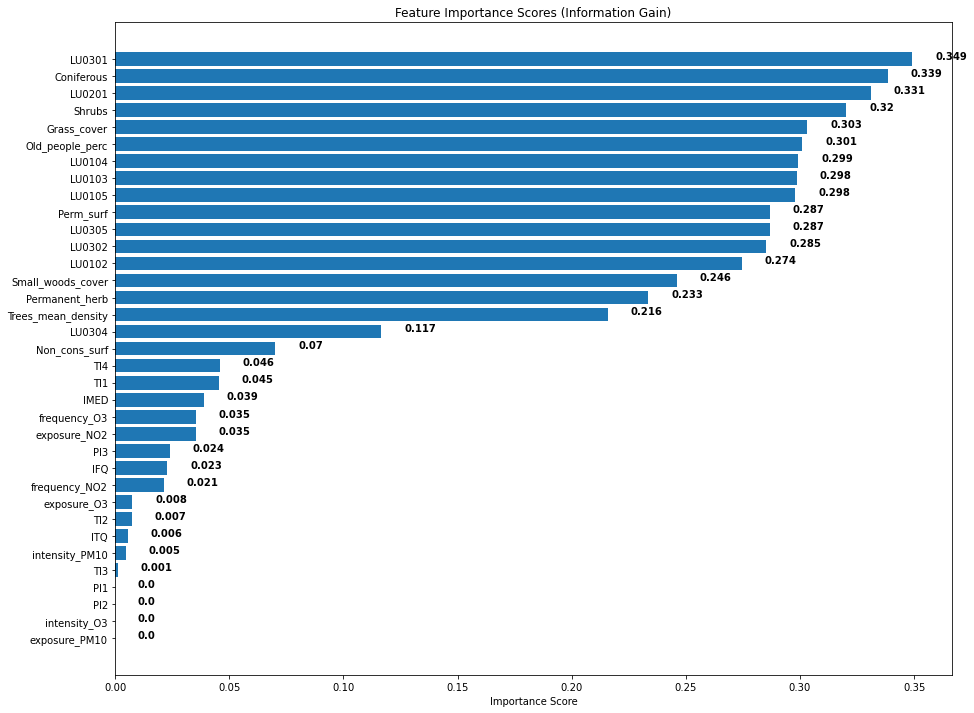

In [53]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import numpy as np

# Apply Information Gain
ig = mutual_info_regression(X, y)

# Create a dictionary of feature importance scores
feature_scores = {}
for i in range(len(X_train.columns)):
    feature_scores[X_train.columns[i]] = ig[i]
# Sort the features by importance score in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance scores and the sorted features
for feature, score in sorted_features:
    print("Feature:", feature, "Score:", score)
# Plot a horizontal bar chart of the feature importance scores
fig, ax = plt.subplots(figsize=(15,12))
y_pos = np.arange(len(sorted_features))
ax.barh(y_pos, [score for feature, score in sorted_features], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels([feature for feature, score in sorted_features])
ax.invert_yaxis()  # Labels read top-to-bottom
ax.set_xlabel("Importance Score")
ax.set_title("Feature Importance Scores (Information Gain)")

# Add importance scores as labels on the horizontal bar chart
for i, v in enumerate([score for feature, score in sorted_features]):
    ax.text(v + 0.01, i, str(round(v, 3)), color="black", fontweight="bold")
plt.show()

# Simulations

In [106]:
from sklearn.linear_model import LinearRegression

old_people_perc_synthetic = []

for i in range(0, len(data), 4):
    X_coord = np.array([2013, 2014, 2015, 2016]).reshape((-1, 1))
    y_coord = np.array([data['Old_people_perc'][i], data['Old_people_perc'][i+1], data['Old_people_perc'][i+2], data['Old_people_perc'][i+3]])
    model = LinearRegression().fit(X_coord, y_coord)
    new_x_coord = np.array([2021]).reshape((-1, 1))
    y_pred_2021 = model.predict(new_x_coord)
    old_people_perc_synthetic.append(y_pred_2021[0])

In [118]:
# Change only age of citizens

synthetic_data = data.iloc[3:len(data):4,:]
synthetic_data['Old_people_perc'] = old_people_perc_synthetic

C:\Users\alber\AppData\Local\Temp\ipykernel_11332\4025848062.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthetic_data['Old_people_perc'] = old_people_perc_synthetic


In [124]:
synthetic_data = synthetic_data[X_test.columns]
y_pred_proba_synthetic = best_model.predict_proba(synthetic_data)

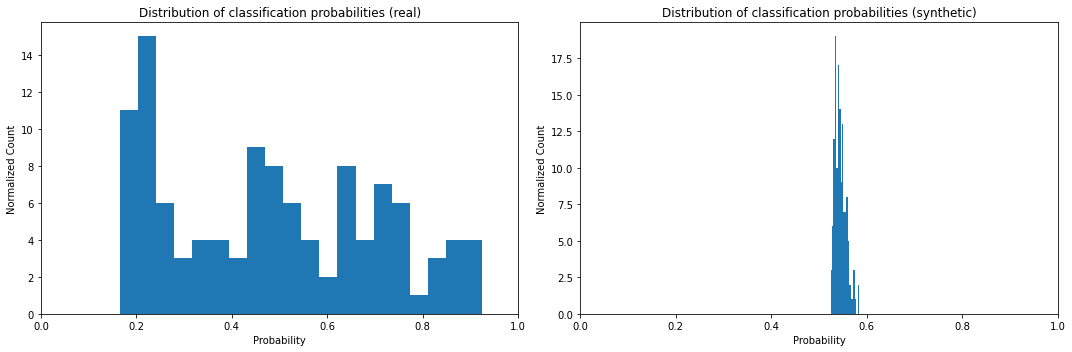

In [181]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(15, 5))

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(y_pred_proba[:,1], bins=20)
axs[0].set_title('Distribution of classification probabilities (real)')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Normalized Count')
axs[0].set_xlim((0, 1))
axs[1].hist(y_pred_proba_synthetic[:,1], bins=20)
axs[1].set_title('Distribution of classification probabilities (synthetic)')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Normalized Count')
axs[1].set_xlim((0, 1))

plt.show()